In [2]:
#!/usr/bin/env python

'''
GA Data Science Q2 2016

Code walk-through 5: Linear regression using scikit-learn

* Linear regression
* Cross-validation
* Regularisation:
  - L1 penalty (LASSO)
  - L2 penalty (Ridge)
  - Elastic Net
'''

import os

import numpy as np
import pandas as pd

from sklearn import linear_model as lm
from sklearn import metrics
from sklearn import cross_validation as cv
from sklearn import grid_search

import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# Read in the National Child Development Study data
ncds = pd.read_csv(r'..\..\Data\ncds.csv')

# Define predictors and response
predictors = ['n920', 'n923', 'n926', 'n851', 'n852']
response = 'earngsn'

all_vars = predictors + [response]

# Recode missing values
ncds.where(ncds[all_vars] > 0, inplace=True)

# Remove missing values
ncds.dropna(subset=all_vars, inplace=True)

In [6]:
'''
Linear regression
'''

# Prepare data
test_scores = ['n920', 'n923', 'n926']
X = ncds[test_scores]
y = ncds[response]

# Fit the model
model1 = lm.LinearRegression()
model1.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
# Print regression coefficients
model1.intercept_
model1.coef_

# Compute the prediction for [45, 20, 20] using `predict`
model1.predict(new_sample)

# Create dummy variables for n851 and n852
# (As an alternative to `dmatrices`; see previous code walk-through)
n851_dummies = pd.get_dummies(ncds.n851.astype('int'), prefix='n851')
n852_dummies = pd.get_dummies(ncds.n852.astype('int'), prefix='n852')

# 'Some interest' used as reference: drop the third column
n851_dummies.drop(n851_dummies.columns[2], axis=1, inplace=True)
n852_dummies.drop(n852_dummies.columns[2], axis=1, inplace=True)

# Concatenate the original DataFrame with the dummies
ncds = pd.concat([ncds, n851_dummies, n852_dummies], axis=1)

# Include dummy variables in the model
predictors = test_scores +\
             n851_dummies.columns.tolist() +\
             n852_dummies.columns.tolist()

# Fit the model
model2 = lm.LinearRegression()
model2.fit(ncds[predictors], ncds[response])

# Print regression coefficients
model2.intercept_
model2.coef_

# Pair variable names and coefficients
list(zip(predictors, model2.coef_))

[('n920', -0.19566718481399964),
 ('n923', 0.30968450087465266),
 ('n926', 0.37659598176545095),
 ('n851_1', 5.5221054569127643),
 ('n851_2', 0.8025873514195796),
 ('n851_4', -1.8329396497029815),
 ('n851_5', -2.1156635729003792),
 ('n852_1', -1.0562685293873795),
 ('n852_2', -1.8590128537519477),
 ('n852_4', 2.5263989304738352),
 ('n852_5', 1.9146200760789165)]

In [11]:
'''
Cross-validation
'''

# Define 10 folds
kf = cv.KFold(len(ncds), n_folds=10, shuffle=True)

# Compute MSEs (one per fold)
mses = []
for train_idx, test_idx in kf:
    model = lm.LinearRegression()
    model.fit(ncds[predictors].iloc[train_idx], ncds[response].iloc[train_idx])
    mses.append(metrics.mean_squared_error(
        ncds[response].iloc[test_idx],
        model.predict(ncds[predictors].iloc[test_idx])
    ))
    
# Compute average MSE across folds
np.mean(mses)

871.79733616183307

In [13]:
# Alternatively, using `cross_val_score`…
mses = cv.cross_val_score(lm.LinearRegression(),\
                          ncds[predictors], ncds[response],\
                          scoring='mean_squared_error', cv=10)

(-cv_mse).mean()

In [15]:
'''
Regularisation: L1 penalty (LASSO)
'''

# Fit the model (by default, alpha = 1)
model2_lasso = lm.Lasso().fit(ncds[predictors], ncds[response])

# Print regression coefficients
model2_lasso.intercept_
list(zip(predictors, model2_lasso.coef_))

[('n920', -0.16259362021694598),
 ('n923', 0.23579640179879349),
 ('n926', 0.34455314317706615),
 ('n851_1', 0.0),
 ('n851_2', -0.0),
 ('n851_4', 0.0),
 ('n851_5', -0.0),
 ('n852_1', 0.0),
 ('n852_2', -0.0),
 ('n852_4', 0.0),
 ('n852_5', 0.0)]

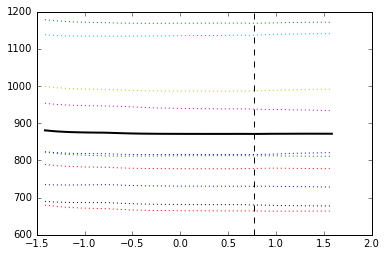

In [16]:
# Compute MSE
metrics.mean_squared_error(ncds[response], model2_lasso.predict(ncds[predictors]))

# Determine ‘optimal’ value of alpha using grid search with cross-validation
gs = grid_search.GridSearchCV(estimator=lm.Lasso(),\
                              param_grid={'alpha': np.logspace(-10, 10, 21)},\
                              cv=kf,
                              scoring='mean_squared_error')

gs.fit(ncds[predictors], ncds[response])

# ‘Best’ MSE (fixing the sign again)
-gs.best_score_

# ‘Best’ model (includes value of alpha)
gs.best_estimator_

# All grid configurations and corresponding performances
gs.grid_scores_

# Alternatively, using `LassoCV`…
model2_lasso = lm.LassoCV(cv=kf).fit(ncds[predictors], ncds[response])

# Plot (average) MSE across folds versus alpha
nlog_alphas = -np.log10(model2_lasso.alphas_)
plt.figure()
plt.plot(nlog_alphas, model2_lasso.mse_path_, ':')
plt.plot(nlog_alphas, model2_lasso.mse_path_.mean(axis=-1), linewidth=2, color='k')
plt.axvline(-np.log10(model2_lasso.alpha_), linestyle='--', color='k')

In [ ]:

'''
Regularisation: L2 penalty (Ridge)
'''

# Fit the model (by default, alpha = 1)
model2_ridge = lm.Ridge().fit(ncds[predictors], ncds[response])

# Print regression coefficients
model2_ridge.intercept_
list(zip(predictors, model2_ridge.coef_))

# Compute MSE
metrics.mean_squared_error(ncds[response], model2_ridge.predict(ncds[predictors]))

# Determine ‘optimal’ value of alpha using grid search with cross-validation
gs = grid_search.GridSearchCV(estimator=lm.Ridge(),\
                              param_grid={'alpha': np.logspace(-10, 10, 21)},\
                              cv=kf,
                              scoring='mean_squared_error')

gs.fit(ncds[predictors], ncds[response])

# ‘Best’ MSE (fixing the sign again)
-gs.best_score_

# ‘Best’ model (includes value of alpha)
gs.best_estimator_

# All grid configurations and corresponding performances
gs.grid_scores_

